In [5]:
import keras.layers as layers
from keras.models import Sequential, Model
import keras.backend as K

import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt

from simpler_utils import load_data
import h5py
from tqdm import tqdm

In [6]:
plt.style.use('ggplot')

plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': 'Computer Modern Roman',
    'font.size': 20
})

cmap = plt.get_cmap('plasma')

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Loading the data 

$$
\begin{aligned}
    \texttt{X}_{\texttt{train}}, \texttt{y}_{\texttt{train}} &= X, y \\
    \texttt{modac} &= m
\end{aligned}
$$

- $X$ is the tensor of all the training data.
- $y$ is the tensor of one-hot encoded scene label for the training data
- $m$ is the tensor of acquisition modality labels.

In [8]:
meta_path = './meta.csv'
features_path = './data/features.h5'

X_train, y_train, true_labels, modac, data_size = load_data(features_path, meta_path, 'Train')
modac = np.array(modac)
true_labels = np.array(true_labels)
modac_labels = np.unique(modac)
scene_labels = np.unique(true_labels)

In [9]:
print(f'Shape of X_train: {X_train.shape}')
print(f'X_train elements look like :\n {X_train[0][:5,:5,0]}\n')

print(f'Shape of y_train: {y_train.shape}')
print(f'y_train elements look like :\n {tf.transpose(y_train[0])}\n')

print(f'Shape of true_labels: {true_labels.shape}')
print(f'true_labels elements look like :"{true_labels[0]}"\n')

print(f'Shape of modac: {modac.shape}') 
print(f'modac elements look like :"{modac[0]}"\n')

Shape of X_train: (139620, 40, 51, 1)
X_train elements look like :
 [[-0.12775049 -0.09982605 -0.07846308 -0.04144414 -0.06006043]
 [-0.17505418 -0.09564501 -0.07840205 -0.07757805 -0.12488174]
 [-0.20868556 -0.12973419 -0.10657064 -0.13061923 -0.09204382]
 [-0.24066897 -0.12182989 -0.16821803 -0.14139226 -0.137669  ]
 [-0.18875699 -0.07766961 -0.06228828 -0.04547258 -0.07388531]]

Shape of y_train: (139620, 10, 1)
y_train elements look like :
 [[0.91 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]]

Shape of true_labels: (139620,)
true_labels elements look like :"airport"

Shape of modac: (139620,)
modac elements look like :"a"



In [10]:
print(f'Are they all of the same first dimension? {np.alltrue([X_train.shape[0] == y_train.shape[0], X_train.shape[0] == true_labels.shape[0], X_train.shape[0] == modac.shape[0]])}')

Are they all of the same first dimension? True


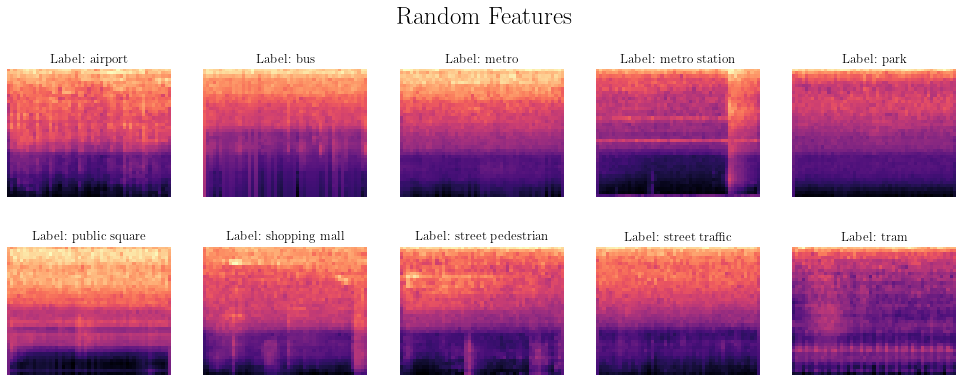

In [11]:
fig, ax = plt.subplots(2,5, figsize=(17,6))
fig.suptitle(r'Random Features', fontsize=25, x=0.515, y=1.)


def mapping(x): return (x[1])*5 + ((x[0]) % 5) + 1

for i in range(5):
    for j in range(2):
        index = np.random.choice(np.where(true_labels == scene_labels[mapping([i,j])-1])[0])
        ax[j, i].imshow(X_train[index,:,:,0], cmap='magma')
        ax[j, i].set_title(f'Label: {scene_labels[mapping([i,j])-1].replace("_", " ")}', fontsize=13)
        ax[j, i].axis('off')

In [12]:
scene_labels = np.unique(true_labels)
print(f'There are {len(scene_labels)} scene labels')
print(f'The scene labels are {scene_labels}\n')

print('{ColA: <20}| {ColB}  | {ColC}'.format(
    ColA='Scene Label', ColB='Count', ColC='Percentage'))
print('-'*40)
for label in scene_labels:
    print(f'{label: <20}| {np.sum(true_labels == label)}  | {np.sum(true_labels == label)/len(true_labels)*100:.2f}%')
print('-'*40)
print('{ColA: <20}| {ColB} | {ColC} %'.format(ColA='Total', ColB=len(true_labels), ColC=np.sum(
    np.sum(true_labels == label)/len(true_labels)*100 for label in scene_labels)))

There are 10 scene labels
The scene labels are ['airport' 'bus' 'metro' 'metro_station' 'park' 'public_square'
 'shopping_mall' 'street_pedestrian' 'street_traffic' 'tram']

Scene Label         | Count  | Percentage
----------------------------------------
airport             | 13930  | 9.98%
bus                 | 14000  | 10.03%
metro               | 13820  | 9.90%
metro_station       | 13800  | 9.88%
park                | 14290  | 10.23%
public_square       | 14270  | 10.22%
shopping_mall       | 13730  | 9.83%
street_pedestrian   | 13860  | 9.93%
street_traffic      | 14130  | 10.12%
tram                | 13790  | 9.88%
----------------------------------------
Total               | 139620 | 100.0 %


/home/ncurcuma/miniconda3/envs/tf2-dcase/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  if sys.path[0] == '':


In [13]:
modac_labels = np.unique(modac)
print(f'There are {len(modac_labels)} modac labels')
print(f'Modac labels are {modac_labels}\n')

print('{ColA: <20}| {ColB}  | {ColC}'.format(
    ColA='Modac Label', ColB='Count', ColC='Percentage'))
print('-'*40)
for label in modac_labels:
    print(f'{label: <20}| {np.sum(modac == label)}  | {np.sum(modac == label)/len(modac)*100:.2f}%')
print('-'*40)
print('{ColA: <20}| {ColB} | {ColC} %'.format(ColA='Total', ColB=len(modac), ColC=np.sum(
    np.sum(modac == label)/len(modac)*100 for label in modac_labels)))

There are 6 modac labels
Modac labels are ['a' 'b' 'c' 's1' 's2' 's3']

Modac Label         | Count  | Percentage
----------------------------------------
a                   | 102150  | 73.16%
b                   | 7490  | 5.36%
c                   | 7480  | 5.36%
s1                  | 7500  | 5.37%
s2                  | 7500  | 5.37%
s3                  | 7500  | 5.37%
----------------------------------------
Total               | 139620 | 100.0 %


/home/ncurcuma/miniconda3/envs/tf2-dcase/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  if sys.path[0] == '':


### Loading the model

In [14]:
model = tf.keras.models.load_model('data/base_model/model.tflite')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 51, 16)        800       
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 51, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 40, 51, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 51, 16)        12560     
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 51, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 40, 51, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 10, 16)         0

In [16]:
pred_1 = model.predict(X_train[0:1])
print(f'Looks like {pred_1[0]}')
print(f'Prediction for first element is "{scene_labels[np.argmax(pred_1[0])]}"')
print(f'True label was "{true_labels[0]}"')


Looks like [0.4193899  0.00923973 0.01117449 0.01380068 0.00518412 0.0186777
 0.46922314 0.03495952 0.01051959 0.00783111]
Prediction for first element is "shopping_mall"
True label was "airport"


In [17]:
y_pred = model.predict(X_train) # computing all predictions one time

### Statistics on the data and the predictions

In [18]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

In [19]:
def computeMetrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred, average='weighted'),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'confusion_matrix': confusion_matrix(y_true, y_pred, normalize='true')
    }

In [20]:
overall_metrics = computeMetrics(true_labels, np.array([scene_labels[np.argmax(pred)] for pred in y_pred]))

In [21]:
for key, value in overall_metrics.items():
    if key == 'confusion_matrix':
        displayed_values = np.array2string(value, formatter={'float_kind':lambda x: "%.2f" % x})
        print(f'\n{key}:\n{displayed_values}')
    else:
        # print it with 2 decimal places and with values aligned to the right
        print(f'{key:<15}: {100*value:.2f} %')

accuracy       : 71.50 %
f1             : 71.59 %
precision      : 72.09 %
recall         : 71.50 %

confusion_matrix:
[[0.72 0.00 0.00 0.03 0.00 0.03 0.08 0.12 0.00 0.00]
 [0.00 0.69 0.05 0.02 0.01 0.03 0.00 0.01 0.02 0.18]
 [0.00 0.05 0.66 0.07 0.01 0.01 0.00 0.01 0.02 0.16]
 [0.06 0.02 0.10 0.63 0.01 0.02 0.04 0.06 0.03 0.04]
 [0.00 0.00 0.00 0.00 0.91 0.03 0.00 0.01 0.03 0.01]
 [0.04 0.01 0.01 0.02 0.02 0.65 0.02 0.17 0.05 0.01]
 [0.14 0.00 0.00 0.05 0.00 0.03 0.69 0.08 0.00 0.00]
 [0.11 0.01 0.00 0.02 0.01 0.20 0.04 0.60 0.01 0.01]
 [0.00 0.01 0.01 0.02 0.05 0.07 0.00 0.01 0.83 0.00]
 [0.01 0.07 0.08 0.03 0.02 0.01 0.00 0.02 0.01 0.76]]


In [22]:
modac_metrics = {}

for label in modac_labels:
    modac_metrics[label] = computeMetrics(true_labels[modac == label], np.array([scene_labels[np.argmax(pred)] for pred in y_pred[modac == label]]))

In [23]:
for label in modac_labels:
    print(f'{label:<5}: {100*modac_metrics[label]["accuracy"]:.2f} %')

a    : 75.37 %
b    : 56.14 %
c    : 63.73 %
s1   : 59.28 %
s2   : 63.77 %
s3   : 61.73 %


In [24]:
scene_label_metrics = {}

for label in scene_labels:
    scene_label_metrics[label] = computeMetrics(true_labels[true_labels == label], np.array([scene_labels[np.argmax(pred)] for pred in y_pred[true_labels == label]]))

In [25]:
for scene_label in scene_labels:
    print(f'{scene_label:<20}: {100*scene_label_metrics[scene_label]["accuracy"]:.2f} %')

airport             : 72.23 %
bus                 : 68.95 %
metro               : 66.40 %
metro_station       : 62.51 %
park                : 90.63 %
public_square       : 64.94 %
shopping_mall       : 69.37 %
street_pedestrian   : 59.65 %
street_traffic      : 83.40 %
tram                : 76.21 %


On veut ajouter le terme de régularisation suivant dans l'optimisation du modèle, si on décompose le réseau classifieur $\Phi$ en deux parties, l'une qui s'arrête à la fin de la couche 2 de convolution et le reste, respectivement noté $\Phi_1$ et $\Phi_2$, tels que $\Phi=\Phi_2\circ\Phi_1$, on peut écrire le terme de régularisation comme suit:

$$
    \mathcal{L}_{\text{reg}}(X, y, m) := \sum_{y_i = y_j \atop m_i\neq m_j}\|\Phi_1(x_i) - \Phi_1(x_j)\|_1
$$

Pour commencer on va calculer, avec le réseau déjà entrainé avec l'objectif de classification uniquement, des métriques. Notamment on va calculer le terme de régularisation pour le jeu de données d'entraînement entier.

In [26]:
model_1 = Model(
    inputs = model.input,
    outputs = model.get_layer('conv2d_1').output
)
model_1.compile()

In [27]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 40, 51, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 51, 16)        800       
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 51, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 40, 51, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 51, 16)        12560     
Total params: 13,424
Trainable params: 13,392
Non-trainable params: 32
_________________________________________________________________


In [28]:
from sklearn.manifold import TSNE

### Selecting 5000 data points with equal number of samples per modac class

In [29]:
number_of_samples = 5000

# 5000 random samples with same number of each modac label
random_distinct_idx = np.array([], dtype=int)
for label in modac_labels:
    random_distinct_idx = np.concatenate((random_distinct_idx, np.random.choice(np.where(modac == label)[0], number_of_samples // len(modac_labels), replace=False)))

true_labels_sample = true_labels[random_distinct_idx]
modac_labels_sample = modac[random_distinct_idx]
X_train_sample = tf.gather(X_train, random_distinct_idx)
y_train_sample = tf.gather(y_train, random_distinct_idx)

In [30]:
print('{Column1:<5} | {Column2:<5}'.format(Column1='Modac', Column2='Count'))
print('-'*13)
for modac_label in modac_labels:
    print(f'{modac_label:<5} | {len(np.where(modac_labels_sample == modac_label)[0])}')
print('\n\n')

print('{Column1:<20} | {Column2:<7} | {Column3:<5}'.format(Column1='Scene Label', Column2='Count', Column3='Percentage'))
print('-'*40)
for scene_label in scene_labels:
    print(f'{scene_label:<20} | {len(np.where(true_labels_sample == scene_label)[0]):<7} | {len(np.where(true_labels_sample == scene_label)[0])/len(true_labels_sample)*100:.2f}%')

Modac | Count
-------------
a     | 833
b     | 833
c     | 833
s1    | 833
s2    | 833
s3    | 833



Scene Label          | Count   | Percentage
----------------------------------------
airport              | 498     | 9.96%
bus                  | 511     | 10.22%
metro                | 503     | 10.06%
metro_station        | 480     | 9.60%
park                 | 513     | 10.26%
public_square        | 493     | 9.86%
shopping_mall        | 493     | 9.86%
street_pedestrian    | 507     | 10.14%
street_traffic       | 505     | 10.10%
tram                 | 495     | 9.90%


In [31]:
model_1_output = model_1.predict(X_train_sample)

In [32]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne.fit(model_1_output.reshape(model_1_output.shape[0], -1))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4998 samples in 0.120s...
[t-SNE] Computed neighbors for 4998 samples in 8.475s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4998
[t-SNE] Computed conditional probabilities for sample 2000 / 4998
[t-SNE] Computed conditional probabilities for sample 3000 / 4998
[t-SNE] Computed conditional probabilities for sample 4000 / 4998
[t-SNE] Computed conditional probabilities for sample 4998 / 4998
[t-SNE] Mean sigma: 220.477385
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.236038
[t-SNE] KL divergence after 300 iterations: 1.735079


TSNE(n_iter=300, perplexity=40, verbose=1)

Text(0.5, 1.0, 't-SNE visualization of the output of the second layer of the model')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


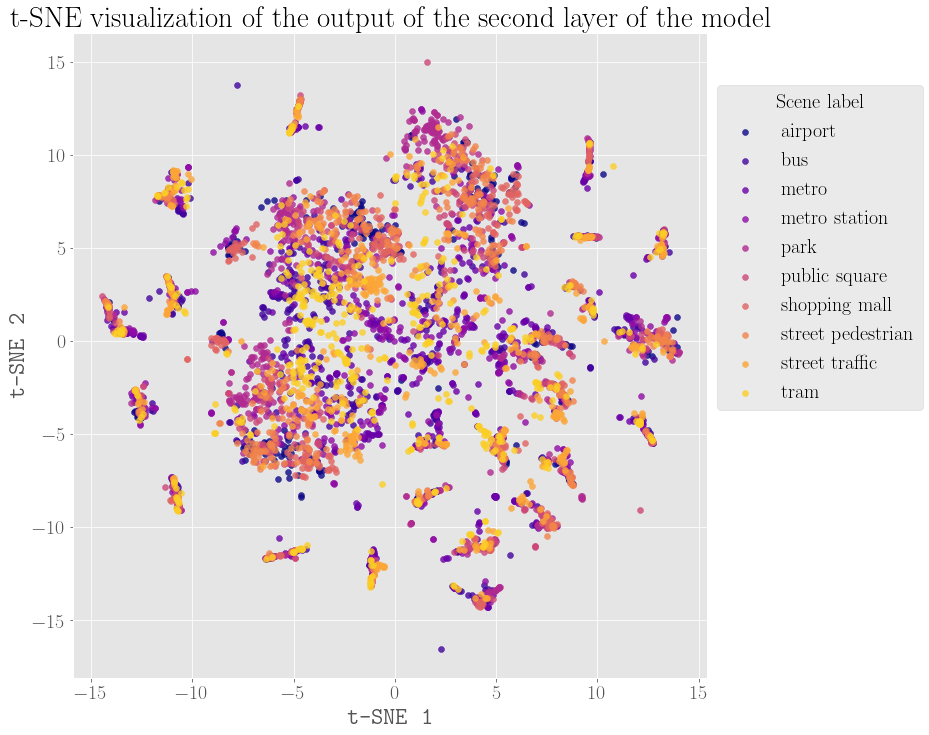

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
fig.tight_layout()

for i, label_name in enumerate(scene_labels):
    label_name_plot = label_name.replace('_', ' ')
    idx = np.where(true_labels_sample == label_name)
    ax.scatter(tsne.embedding_[idx, 0], tsne.embedding_[idx, 1], label=label_name_plot, alpha=0.8, color=cmap(i/len(scene_labels)))


ax.legend(loc='lower left', bbox_to_anchor=(1, 0.4), title='Scene label')

ax.set_xlabel(r'\texttt{t-SNE 1}')
ax.set_ylabel(r'\texttt{t-SNE 2}')
ax.set_title('t-SNE visualization of the output of the second layer of the model')

Text(0.5, 1.0, 't-SNE visualization of the output of the second layer of the model')

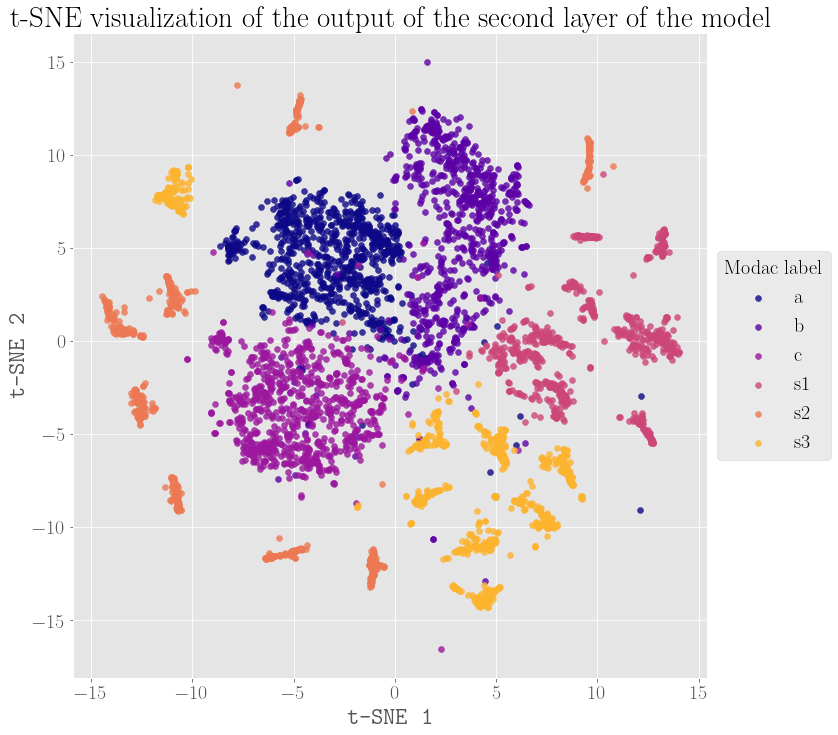

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
fig.tight_layout()

for i, modac_label in enumerate(modac_labels):
    idx = np.where(modac_labels_sample == modac_label)
    ax.scatter(tsne.embedding_[idx, 0], tsne.embedding_[idx, 1], label=modac_label, alpha=0.8, color=cmap(i/len(modac_labels)))
    
ax.legend(ncol=1, loc='center left', bbox_to_anchor=(1, 0.5), title='Modac label')

ax.set_xlabel(r'\texttt{t-SNE 1}')
ax.set_ylabel(r'\texttt{t-SNE 2}')
ax.set_title(
    't-SNE visualization of the output of the second layer of the model')


In [35]:
from sklearn.manifold import Isomap

In [36]:
isomap = Isomap(n_components=2, n_neighbors=10)
isomap.fit(model_1_output.reshape(model_1_output.shape[0], -1))

Isomap(n_neighbors=10)

Text(0.5, 1.0, 'Isomap visualization of the output of the second layer of the model')

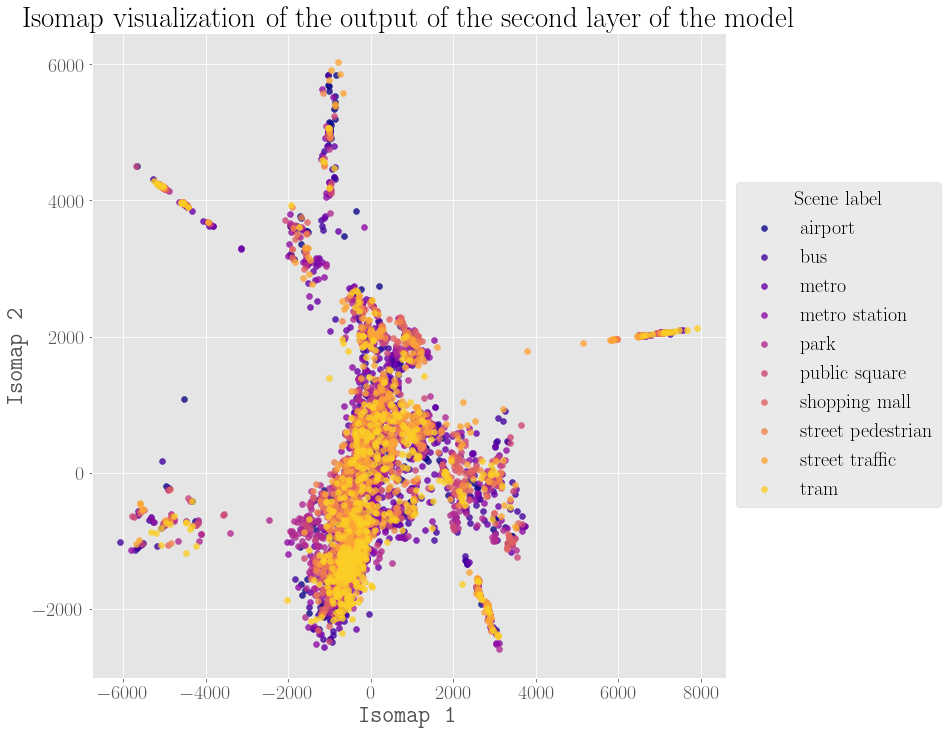

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
fig.tight_layout()

for i, label_name in enumerate(scene_labels):
    label_name_plot = label_name.replace('_', ' ')
    idx = np.where(true_labels_sample == label_name)
    ax.scatter(isomap.embedding_[idx, 0], isomap.embedding_[idx, 1], label=label_name_plot, alpha=0.8, color=cmap(i/len(scene_labels)))

ax.legend(loc='lower left', bbox_to_anchor=(1, 0.25), title='Scene label')
ax.set_xlabel(r'\texttt{Isomap 1}')
ax.set_ylabel(r'\texttt{Isomap 2}')
ax.set_title('Isomap visualization of the output of the second layer of the model')

Text(0.5, 1.0, 'Isomap visualization of the output of the second layer of the model')

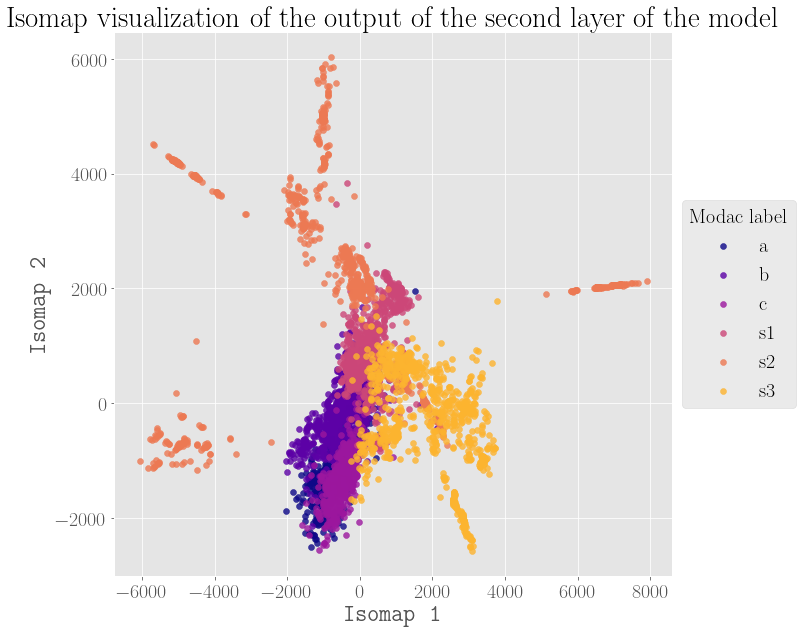

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

for i, modac_label in enumerate(modac_labels):
    idx = np.where(modac_labels_sample == modac_label)
    ax.scatter(isomap.embedding_[idx, 0], isomap.embedding_[idx, 1], label=modac_label, alpha=0.8, color=cmap(i/len(modac_labels)))
    
ax.legend(ncol=1, loc='center left', bbox_to_anchor=(1, 0.5), title='Modac label')
ax.set_xlabel(r'\texttt{Isomap 1}')
ax.set_ylabel(r'\texttt{Isomap 2}')
ax.set_title('Isomap visualization of the output of the second layer of the model')

In [39]:
model_2 = Model(
    inputs = model.input,
    outputs=model.get_layer('conv2d_2').output
)

model_2.compile()

In [40]:
model_2_output = model_2.predict(X_train_sample)

In [41]:
# do a tsne on the outut of the second layer
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne.fit(model_2_output.reshape(model_2_output.shape[0], -1))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4998 samples in 0.010s...
[t-SNE] Computed neighbors for 4998 samples in 1.128s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4998
[t-SNE] Computed conditional probabilities for sample 2000 / 4998
[t-SNE] Computed conditional probabilities for sample 3000 / 4998
[t-SNE] Computed conditional probabilities for sample 4000 / 4998
[t-SNE] Computed conditional probabilities for sample 4998 / 4998
[t-SNE] Mean sigma: 68.685933
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.992447
[t-SNE] KL divergence after 300 iterations: 2.074024


TSNE(n_iter=300, perplexity=40, verbose=1)

Text(0.5, 1.0, 't-SNE visualization of the output of the third layer of the model')

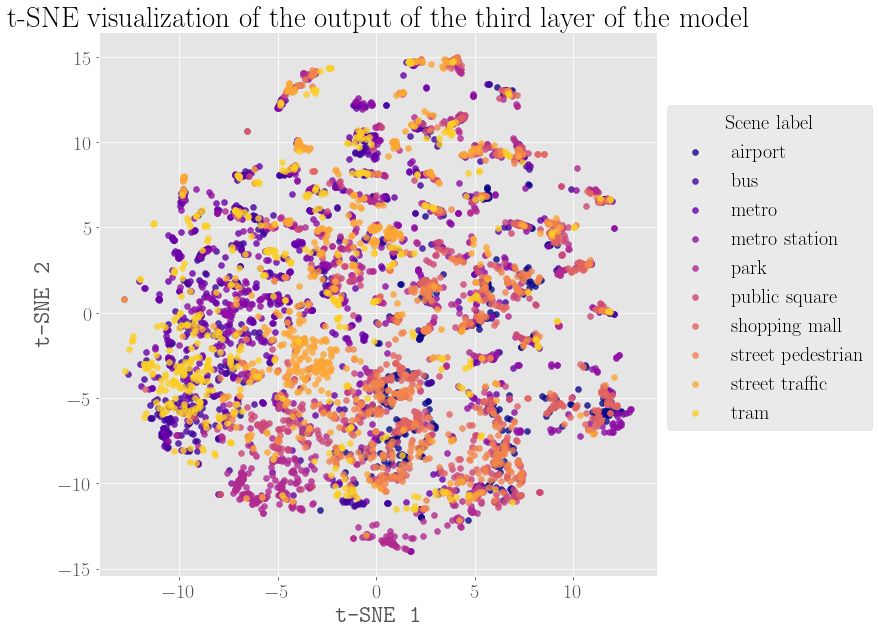

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))

for i, label_name in enumerate(scene_labels):
    label_name_plot = label_name.replace('_', ' ')
    idx = np.where(true_labels_sample == label_name)
    ax.scatter(tsne.embedding_[idx, 0], tsne.embedding_[idx, 1], label=label_name_plot, alpha=0.8, color=cmap(i/len(scene_labels)))

ax.legend(loc='lower left', bbox_to_anchor=(1, 0.25), title='Scene label')
ax.set_xlabel(r'\texttt{t-SNE 1}')
ax.set_ylabel(r'\texttt{t-SNE 2}')
ax.set_title('t-SNE visualization of the output of the third layer of the model')

Text(0.5, 1.0, 't-SNE visualization of the output of the third layer of the model')

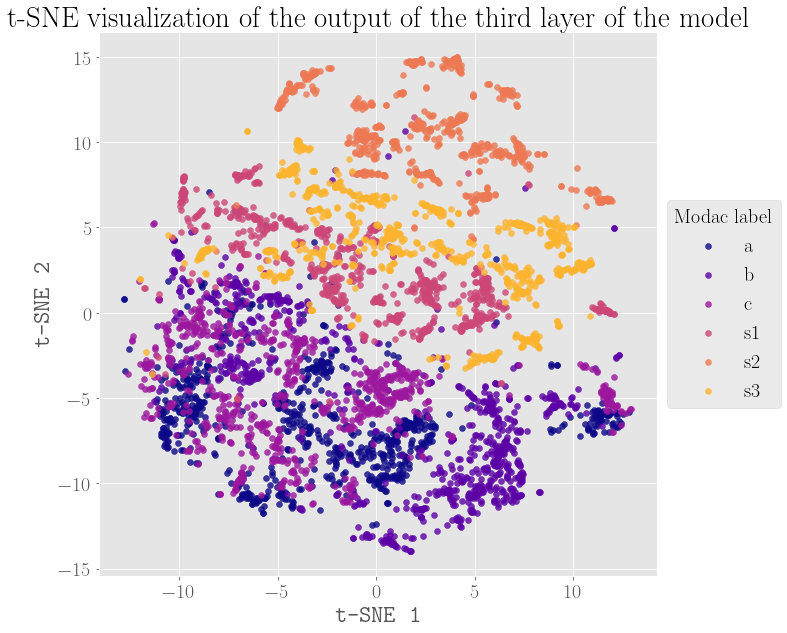

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))

for i, modac_label in enumerate(modac_labels):
    idx = np.where(modac_labels_sample == modac_label)
    ax.scatter(tsne.embedding_[idx, 0], tsne.embedding_[idx, 1], label=modac_label, alpha=0.8, color=cmap(i/len(modac_labels)))

ax.legend(ncol=1, loc='center left', bbox_to_anchor=(1, 0.5), title='Modac label')
ax.set_xlabel(r'\texttt{t-SNE 1}')
ax.set_ylabel(r'\texttt{t-SNE 2}')
ax.set_title('t-SNE visualization of the output of the third layer of the model')

### Study of the dimensionality of clusters in the second layer latent space

In [44]:
from ripser import Rips
from persim import plot_diagrams

In [45]:
rips = Rips()

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [46]:
diagram = rips.fit_transform(model_1_output.reshape(model_1_output.shape[0], -1))

/home/ncurcuma/miniconda3/envs/tf2-dcase/lib/python3.6/site-packages/ripser/ripser.py:255: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  + "did you mean to transpose?"


[Text(0.5, 0, '\\texttt{Birth time}'), Text(0, 0.5, '\\texttt{Death time}')]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


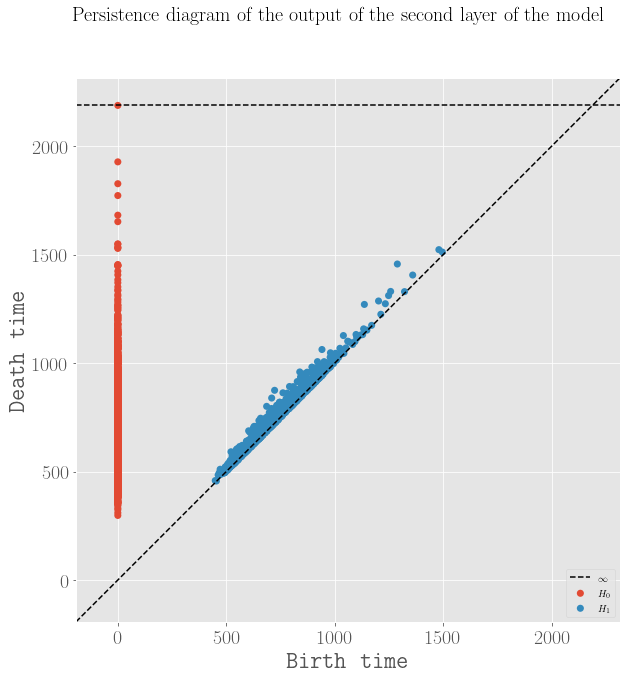

In [47]:
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('Persistence diagram of the output of the second layer of the model', fontsize=20)

plot_diagrams(diagram, show=False, ax=ax, size=50, legend=True, colormap='ggplot')

ax.set(**{
    'xlabel': r'\texttt{Birth time}',
    'ylabel': r'\texttt{Death time}'
})

In [48]:
modac_label_1 = np.random.choice(modac_labels)
modac_label_2 = np.random.choice(modac_labels[modac_labels != modac_label_1])
diagram = rips.fit_transform(model_1_output[(modac_labels_sample == modac_label_1) | (modac_labels_sample == modac_label_2)].reshape(model_1_output.shape[0], -1))
print(f'Persistence diagram for modac label {modac_label_1} and {modac_label_2}')

/home/ncurcuma/miniconda3/envs/tf2-dcase/lib/python3.6/site-packages/ripser/ripser.py:255: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  + "did you mean to transpose?"


Persistence diagram for modac label s1 and s3


[Text(0.5, 0, '\\texttt{Birth time}'), Text(0, 0.5, '\\texttt{Death time}')]

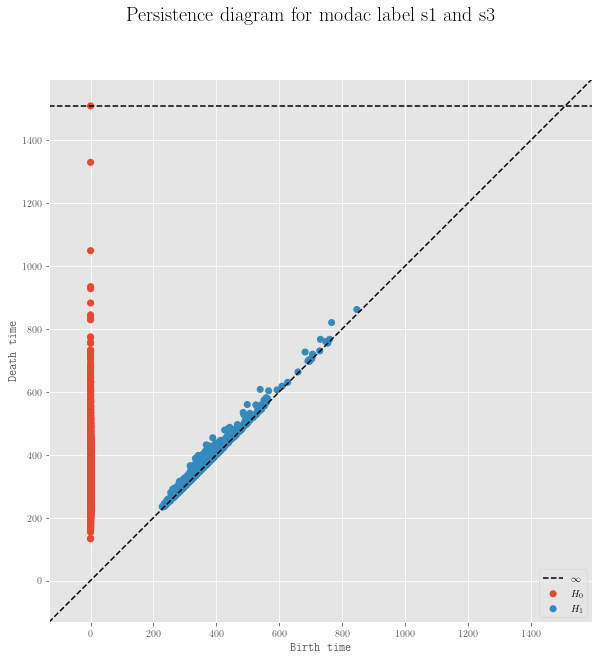

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle(f'Persistence diagram for modac label {modac_label_1} and {modac_label_2}', fontsize=20)

plot_diagrams(diagram, show=False, ax=ax, size=50, legend=True, colormap='ggplot')

ax.set(**{
    'xlabel': r'\texttt{Birth time}',
    'ylabel': r'\texttt{Death time}'
})

In [50]:
diagram = rips.fit_transform(model_1_output[(modac_labels_sample == 's1') | (modac_labels_sample == 's2') | (modac_labels_sample == 's3')].reshape(model_1_output.shape[0], -1))

/home/ncurcuma/miniconda3/envs/tf2-dcase/lib/python3.6/site-packages/ripser/ripser.py:255: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  + "did you mean to transpose?"


[Text(0.5, 0, '\\texttt{Birth time}'), Text(0, 0.5, '\\texttt{Death time}')]

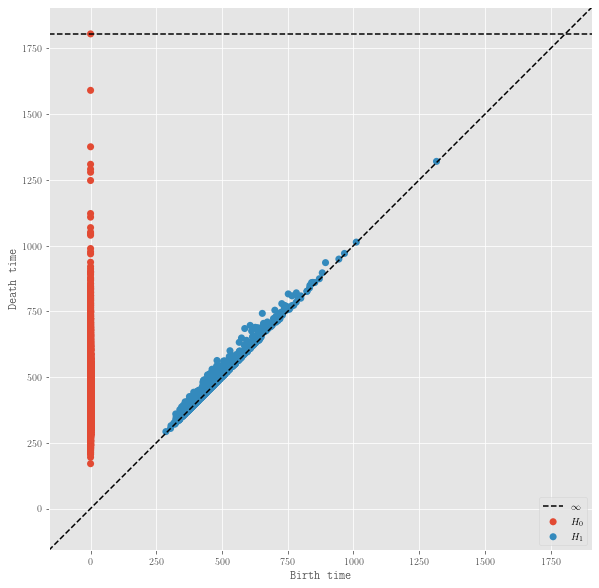

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_diagrams(diagram, show=False, ax=ax, size=50, legend=True, colormap='ggplot')

ax.set(**{
    'xlabel': r'\texttt{Birth time}',
    'ylabel': r'\texttt{Death time}'
})

In [61]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne.fit(model_1_output[
    (modac_labels_sample == 's1') |\
    (modac_labels_sample == 's2') |\
    (modac_labels_sample == 's3')].reshape(model_1_output.shape[0], -1))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4998 samples in 0.055s...
[t-SNE] Computed neighbors for 4998 samples in 2.910s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4998
[t-SNE] Computed conditional probabilities for sample 2000 / 4998
[t-SNE] Computed conditional probabilities for sample 3000 / 4998
[t-SNE] Computed conditional probabilities for sample 4000 / 4998
[t-SNE] Computed conditional probabilities for sample 4998 / 4998
[t-SNE] Mean sigma: 156.305215
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.427628
[t-SNE] KL divergence after 300 iterations: 1.605648


TSNE(n_iter=300, perplexity=40, verbose=1)

Text(0.5, 1.0, 't-SNE visualization of the output of the second layer of the model')

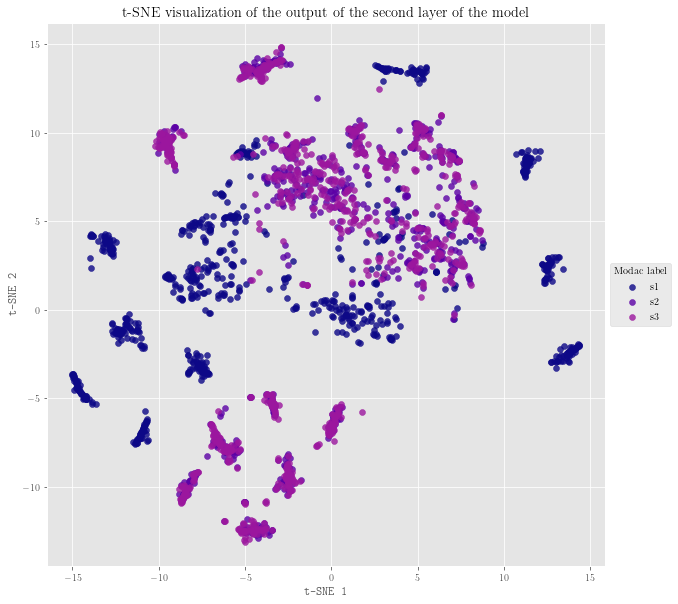

In [53]:
fig, ax = plt.subplots(figsize=(10, 10))

for i, modac_label in enumerate(['s1', 's2', 's3']):
    idx = np.where(modac_labels_sample == modac_label)
    ax.scatter(tsne.embedding_[idx, 0], tsne.embedding_[idx, 1], label=modac_label, alpha=0.8, color=cmap(i/len(modac_labels)))
    
ax.legend(ncol=1, loc='center left', bbox_to_anchor=(1, 0.5), title='Modac label')
ax.set_xlabel(r'\texttt{t-SNE 1}')
ax.set_ylabel(r'\texttt{t-SNE 2}')
ax.set_title('t-SNE visualization of the output of the second layer of the model')

## Training the model, siamese network

On veut pouvoir entrainer un modèle qui minimise l'objectif suivant:

$$
    \mathcal{L}(X, y, m) := \mathcal{L}_{\text{class}}(X, y, m) + \lambda\mathcal{L}_{\text{reg}}(X, y, m)
$$

où les fonctions $\mathcal{L}_{\text{class}}$ est la fonction `categorical_crossentropy` de Keras et $\mathcal{L}_{\text{reg}}$ est la fonction de régularisation que l'on a définie précédemment.

$$
\begin{aligned}
    \mathcal{L}_{\text{class}}(X, y) &= \sum_{i=1}^n y_{i}\log(\Phi(x_i)) \\
    \mathcal{L}_{\text{reg}}(X, y, m) &= \sum_{y_i = y_j \atop m_i\neq m_j}\|\Phi_1(x_i) - \Phi_1(x_j)\|_1
\end{aligned}
$$

(ici $\Phi$ désigne le vecteur de probabilité pour chaque classe de scène.)

D'abord

On va faire une implémentation de la boucle d'entrainement à la main en pur tensorflow, pour pouvoir avoir plus de contrôle sur les opérations. D'abord on va faire une petite boucle d'entrainement pour le modèle sans la régularisation.

In [54]:
from tensorflow.keras.losses import CategoricalCrossentropy

categorical_crossentropy = CategoricalCrossentropy()

In [55]:
print(f'Categorical cross entropy on the actual trained network: {categorical_crossentropy(y_train[:,:,0], y_pred).numpy()}')

Categorical cross entropy on the actual trained network: 1.1425710916519165


In [56]:
from keras.models import clone_model

In [100]:
model_copy = clone_model(model)

for layer in model_copy.layers:
    weights = layer.get_weights()
    weights = [np.random.normal(loc=17, scale=5, size=w.shape) for w in weights]
    layer.set_weights(weights)
    
model_copy.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [101]:
y_pred_copy = model_copy.predict(X_train)
print(f'Shape of the output of the model with random weights: {y_pred_copy.shape}')

Shape of the output of the model with random weights: (139620, 10)


In [102]:
print(f'Predicted output for the first sample: {scene_labels[np.argmax(y_pred_copy[0])]}')

Predicted output for the first sample: street_traffic


In [103]:
print(f'Categorical cross entropy on the copy of the network: {categorical_crossentropy(y_train[:,:,0], y_pred_copy).numpy()}')

Categorical cross entropy on the copy of the network: 14.488828659057617


In [66]:
model_copy.layers[-1].get_weights()[0][0]

array([ 2.2541053 , -0.30721846, -0.70163   , -0.28683695, -0.386351  ,
       -1.81523   , -0.831087  , -0.34383783, -0.03465036, -1.4910117 ],
      dtype=float32)